### 스팀 TOP 100개의 게임 이탈률 분석

# LightGBM 사용

트리기반 머신러닝 모델 (Gradient Boosting)

결정트리(Decision Tree) 를 여러 개 쌓아서 학습하는

Gradient Boosting 계열 머신러닝 모델

| 구분       | LightGBM               | XGBoost                |
| -------- | ---------------------- | ---------------------- |
| 기본 알고리즘  | Gradient Boosting Tree | Gradient Boosting Tree |
| 트리 성장 방식 | **Leaf-wise (비대칭)**    | **Level-wise (대칭)**    |
| 학습 속도    | ⭐⭐⭐⭐ 매우 빠름             | ⭐⭐⭐ 보통                 |
| 메모리 사용   | 적음                     | 상대적으로 큼                |
| 대용량 데이터  | ⭐⭐⭐⭐ 매우 강함             | ⭐⭐⭐                    |
| 소규모 데이터  | 과적합 위험                 | ⭐⭐⭐⭐ 안정                |
| 기본 성능    | 높음                     | 높음                     |
| 튜닝 난이도   | 낮음                     | 중간~높음                  |
| 실무 사용 빈도 | 매우 높음                  | 매우 높음                  |


# 0. 라이브러리 import

In [2]:
import numpy as np                                      # 각종 수치 계산
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.datasets import load_breast_cancer         # 유방암 데이터셋 예제
from sklearn.model_selection import train_test_split    # 학습 / 검증 / 테스트 데이터 셋 분리
from sklearn.preprocessing import StandardScaler        # 입력 특성 표준화 (z-core)
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix,
    precision_score, recall_score, accuracy_score, f1_score,
    precision_recall_curve
    )

import torch                            # Tensor 조작 및 기본 패키지
import torch.nn as nn                   # 신경망 레이어 모델 정의
import torch.optim as optim             # 옵티마이저 (최적화 함수 : SGD, Adam 등 )
from torch.utils.data import TensorDataset,dataloader # Dataset 구성


import warnings                         # 파이썬 에러 메세지 제어 
warnings.filterwarnings('ignore')       # 불필요한 warning 메시지 제거

In [3]:
#한글패치
plt.rcParams["font.family"] = "Malgun Gothic" # 한글 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

0. 데이터 확인

In [4]:
df = pd.read_csv("./data/260108_reviews_joined_all_matched.csv")
df.head()

appid  recommendationid            steamid  num_games_owned  \
0  2139460         199685023  76561198220582271               23   
1  2139460         199684668  76561198401253542                0   
2  2139460         199683985  76561199435851437                0   
3  2139460         199683578  76561198977144059               83   
4  2139460         199683575  76561199109403538                0   

   num_reviews_author  playtime_forever  playtime_last_two_weeks  \
0                   1           15240.0                      0.0   
1                   1            6249.0                      0.0   
2                   1           20522.0                      0.0   
3                  30           22726.0                      0.0   
4                   1            2747.0                      0.0   

   playtime_at_review  deck_playtime_at_review   last_played  ...  \
0               15240                      NaN  1.748034e+09  ...   
1                 834                      NaN  1.755746e+09  ...   
2               12327                      NaN  1.755124e+09  ...   
3                4090                      NaN  1.755366e+09  ...   
4                2389                      NaN  1.752985e+09  ...   

  comment_count steam_purchase  received_for_free  \
0             1          False              False   
1             0          False              False   
2             0          False              False   
3             0          False              False   
4             0          False              False   

   written_during_early_access  developer_response  timestamp_dev_responded  \
0                        False                 NaN                      NaN   
1                        False                 NaN                      NaN   
2                        False                 NaN                      NaN   
3                        False                 NaN                      NaN   
4                        False                 NaN                      NaN   

   primarily_steam_deck  appid_1   game_name  \
0                 False  2139460  Once Human   
1                 False  2139460  Once Human   
2                 False  2139460  Once Human   
3                 False  2139460  Once Human   
4                 False  2139460  Once Human   

                                               genre  
0  ['Action', 'Adventure', 'RPG', 'Simulation', '...  
1  ['Action', 'Adventure', 'RPG', 'Simulation', '...  
2  ['Action', 'Adventure', 'RPG', 'Simulation', '...  
3  ['Action', 'Adventure', 'RPG', 'Simulation', '...  
4  ['Action', 'Adventure', 'RPG', 'Simulation', '...  

[5 rows x 28 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030656 entries, 0 to 1030655
Data columns (total 28 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   appid                        1030656 non-null  int64  
 1   recommendationid             1030656 non-null  int64  
 2   steamid                      1030656 non-null  int64  
 3   num_games_owned              1030656 non-null  int64  
 4   num_reviews_author           1030656 non-null  int64  
 5   playtime_forever             1030645 non-null  float64
 6   playtime_last_two_weeks      1030645 non-null  float64
 7   playtime_at_review           1030656 non-null  int64  
 8   deck_playtime_at_review      19544 non-null    float64
 9   last_played                  1030645 non-null  float64
 10  language                     1030656 non-null  object 
 11  review                       1027088 non-null  object 
 12  timestamp_created            1030656 non-n

0.1 컬럼명 및 정수 여부

| 컬럼명(한글) | 컬럼명(영어) | 설명 | 분포(실제 분포) |
|---|---|---|---|
| 게임 ID | appid | Steam 게임 고유 ID | 440 ~ 3,241,660 (mean≈1,239,968) |
| 리뷰 추천 ID | recommendationid | 리뷰 고유 식별자 | 약 1.99e8 ~ 2.15e8 |
| 유저 Steam ID | steamid | 리뷰 작성자 Steam ID | 거의 단일값, 분산 매우 작음 |
| 보유 게임 수 | num_games_owned | 유저가 보유한 전체 게임 수 | 0 ~ 7,706 (median 0, mean 55.9) |
| 작성 리뷰 수 | num_reviews_author | 유저가 작성한 전체 리뷰 수 | 1 ~ 2,542 (median 3) |
| 누적 플레이 타임 | playtime_forever | 해당 게임 총 플레이 시간 | 5 ~ 1,457,369 |
| 최근 2주 플레이 타임 | playtime_last_two_weeks | 최근 2주간 플레이 시간 | 0 ~ 17,144 (75% ≤ 370) |
| 리뷰 시점 플레이 타임 | playtime_at_review | 리뷰 작성 시점 누적 플레이 시간 | 5 ~ 1,396,679 |
| Steam Deck 플레이 타임 | deck_playtime_at_review | 리뷰 시점 Steam Deck 플레이 시간 | 1 ~ 51,724 (표본 적음) |
| 마지막 플레이 시각 | last_played | 마지막 플레이 시점 (Unix) | 1.47e9 ~ 1.77e9 |
| 리뷰 생성 시각 | timestamp_created | 리뷰 최초 작성 시각 (Unix) | 1.75e9 ~ 1.77e9 |
| 리뷰 수정 시각 | timestamp_updated | 리뷰 최종 수정 시각 (Unix) | 생성 시각과 거의 동일 |
| 긍정 추천 여부 | voted_up | 긍정 리뷰 여부 (1=긍정) | mean 0.633 (긍정 약 63%) |
| 도움됨 투표 수 | votes_up | 도움이 됐다고 평가한 수 | 0 ~ 1,511 (대부분 0) |
| 재미있음 투표 수 | votes_funny | 재미있다고 평가한 수 | 0 ~ 438 (대부분 0) |
| 가중 투표 점수 | weighted_vote_score | Steam 내부 도움도 점수 | 0.29 ~ 0.95 (median 0.5) |
| 댓글 수 | comment_count | 리뷰에 달린 댓글 수 | 0 ~ 14 (99% 이상 0) |
| 개발자 응답 시각 | timestamp_dev_responded | 개발자 답변 시각 (Unix) | 존재 데이터 56건 |
| Steam 구매 여부 | steam_purchase | Steam에서 구매했는지 여부 | 없음 |
| 무료 획득 여부 | received_for_free | 무료로 받았는지 여부 | 없음 |
| 얼리액세스 작성 여부 | written_during_early_access | 얼리액세스 중 작성 여부 | 없음 |
| 리뷰 언어 | language | 리뷰 작성 언어 | 없음 |
| 리뷰 텍스트 | review | 리뷰 본문 텍스트 | 없음 |
| 개발자 응답 내용 | developer_response | 개발자 답변 텍스트 | 없음 |
| Steam Deck 주 사용 여부 | primarily_steam_deck | Steam Deck 위주 플레이 여부 | 없음 |
| 중복 appid | appid_1 | appid 중복 컬럼 | appid와 동일 |
| 난수 컬럼 | rnd | 무작위 샘플링용 컬럼 | 0 ~ 0.019 |


0.2 결측치 확인 및 수정

In [6]:
#결측치 확인
df.isnull().sum()

appid                                0
recommendationid                     0
steamid                              0
num_games_owned                      0
num_reviews_author                   0
playtime_forever                    11
playtime_last_two_weeks             11
playtime_at_review                   0
deck_playtime_at_review        1011112
last_played                         11
language                             0
review                            3568
timestamp_created                    0
timestamp_updated                    0
voted_up                             0
votes_up                             0
votes_funny                          0
weighted_vote_score                  0
comment_count                        0
steam_purchase                       0
received_for_free                    0
written_during_early_access          0
developer_response             1027150
timestamp_dev_responded        1027150
primarily_steam_deck                 0
appid_1                  

In [7]:
# 수치형 플레이타임 계열 0 또는 -1로 대체
playtime_cols = [
    "playtime_forever",
    "playtime_last_two_weeks",
    "last_played"
]

df[playtime_cols] = df[playtime_cols].fillna(0)

In [8]:
# Steam Deck 전용 컬럼 제거 

df["deck_playtime_at_review"] = df["deck_playtime_at_review"].fillna(0)


In [9]:
# 개발자 응답 컬럼 이진변수로 변환
df["has_dev_response"] = df["developer_response"].notna().astype(int)
df.drop(columns=["developer_response", "timestamp_dev_responded"], inplace=True)


In [10]:
# 리뷰 결측지 65개 데이터 "unknown"으로 수정
cat_cols = ['review']

df[cat_cols] = df[cat_cols].fillna("unknown")
df.isnull().sum()


appid                          0
recommendationid               0
steamid                        0
num_games_owned                0
num_reviews_author             0
playtime_forever               0
playtime_last_two_weeks        0
playtime_at_review             0
deck_playtime_at_review        0
last_played                    0
language                       0
review                         0
timestamp_created              0
timestamp_updated              0
voted_up                       0
votes_up                       0
votes_funny                    0
weighted_vote_score            0
comment_count                  0
steam_purchase                 0
received_for_free              0
written_during_early_access    0
primarily_steam_deck           0
appid_1                        0
game_name                      0
genre                          0
has_dev_response               0
dtype: int64

In [11]:
import re
import pandas as pd
import numpy as np

# 1) 언어별 키워드 사전
# - phrases: 문장/구문(부분일치 OK)
# - words: 단어성 키워드(라틴권은 단어경계 \b 적용)
# - neg: 부정 구문(걸리면 good=0으로 처리)
# - boundary: words에 \b를 붙일지 여부 (중국어/일본어/태국어/한국어는 보통 False)
LEXICON = {
    # English
    "english": {
        "phrases": [
            r"highly recommend(?:ed)?",
            r"definitely recommend",
            r"worth (?:buying|it|the money|the time)",
            r"great game",
            r"amazing game",
            r"awesome game",
            r"best game(?:s)?",
        ],
        "words": [
            r"awesome", r"amazing", r"great", r"excellent", r"fantastic", r"incredible",
            r"masterpiece", r"perfect", r"love", r"fun", r"enjoy", r"recommend", r"worth",
        ],
        "neg": [
            r"not\s+good", r"not\s+great", r"not\s+worth",
            r"(?:do\s*not|don't|dont)\s+recommend",
            r"(?:do\s*not|don't|dont)\s+buy",
            r"can't\s+recommend|cant\s+recommend",
            r"avoid\b", r"refund\b",
        ],
        "boundary": True,
    },

    # Spanish (Spain) + LatAm는 같이 처리
    "spanish": {
        "phrases": [r"muy bueno", r"vale la pena", r"lo recomiendo", r"recomendad[oa]"],
        "words": [r"genial", r"excelente", r"buen[oa]", r"incre[ií]ble", r"recomiendo", r"recomendar"],
        "neg": [r"no\s+recomiendo", r"no\s+vale\s+la\s+pena", r"no\s+es\s+buen[oa]", r"no\s+merece\s+la\s+pena", r"no\s+compr(?:es|ar)"],
        "boundary": True,
    },
    "latam": {  # 라틴아메리카 스페인어
        "phrases": [r"muy bueno", r"vale la pena", r"lo recomiendo", r"recomendad[oa]"],
        "words": [r"genial", r"excelente", r"buen[oa]", r"incre[ií]ble", r"recomiendo", r"recomendar"],
        "neg": [r"no\s+recomiendo", r"no\s+vale\s+la\s+pena", r"no\s+es\s+buen[oa]", r"no\s+merece\s+la\s+pena", r"no\s+compr(?:es|ar)"],
        "boundary": True,
    },

    # Portuguese (PT / BR)
    "portuguese": {
        "phrases": [r"vale a pena", r"recomendo", r"muito bom", r"jogo (?:muito )?bom"],
        "words": [r"ótimo", r"excelente", r"incr[ií]vel", r"perfeito", r"divertido", r"recomendar"],
        "neg": [r"não\s+recomendo", r"nao\s+recomendo", r"não\s+vale\s+a\s+pena", r"nao\s+vale\s+a\s+pena", r"não\s+é\s+bom", r"nao\s+e\s+bom", r"não\s+compr(?:e|ar)", r"nao\s+compr(?:e|ar)"],
        "boundary": True,
    },
    "brazilian": {  # 브라질 포르투갈어
        "phrases": [r"vale a pena", r"recomendo", r"muito bom", r"jogo (?:muito )?bom"],
        "words": [r"ótimo", r"excelente", r"incr[ií]vel", r"perfeito", r"divertido", r"recomendar"],
        "neg": [r"não\s+recomendo", r"nao\s+recomendo", r"não\s+vale\s+a\s+pena", r"nao\s+vale\s+a\s+pena", r"não\s+é\s+bom", r"nao\s+e\s+bom", r"não\s+compr(?:e|ar)", r"nao\s+compr(?:e|ar)"],
        "boundary": True,
    },

    # German
    "german": {
        "phrases": [r"sehr gut", r"klare(?:s)? empfehlung", r"lohnt sich", r"absolut empfehl"],
        "words": [r"genial", r"toll", r"super", r"großartig", r"exzellent", r"empfehle", r"empfehlenswert"],
        "neg": [r"nicht\s+empfehl", r"lohnt\s+sich\s+nicht", r"nicht\s+gut", r"kau(?:f|ft)\s+nicht", r"kein\s+kauf"],
        "boundary": True,
    },

    # French
    "french": {
        "phrases": [r"je recommande", r"vaut le coup", r"tr[eè]s bon", r"excellent jeu"],
        "words": [r"g[eé]nial", r"excellent", r"super", r"incroyable", r"parfait", r"recommande"],
        "neg": [r"je\s+ne\s+recommande\s+pas", r"ne\s+vaut\s+pas\s+le\s+coup", r"pas\s+bon", r"n['’]achetez\s+pas", r"n['’]ach[eè]te\s+pas"],
        "boundary": True,
    },

    # Italian
    "italian": {
        "phrases": [r"lo consiglio", r"vale la pena", r"molto bello", r"gioco (?:molto )?bello"],
        "words": [r"fantastico", r"ottimo", r"eccellente", r"stupendo", r"divertente", r"consiglio", r"consigliare"],
        "neg": [r"non\s+lo\s+consiglio", r"non\s+vale\s+la\s+pena", r"non\s+[eè]\s+bello", r"non\s+compr(?:are|atelo)"],
        "boundary": True,
    },

    # Dutch
    "dutch": {
        "phrases": [r"zeker aanraden", r"de moeite waard", r"heel goed", r"geweldig spel"],
        "words": [r"geweldig", r"fantastisch", r"super", r"leuk", r"aanraden", r"aanbevelen", r"waarde"],
        "neg": [r"niet\s+aanrad", r"niet\s+de\s+moeite\s+waard", r"niet\s+goed", r"koop\s+niet"],
        "boundary": True,
    },

    # Swedish / Norwegian / Danish / Finnish
    "swedish": {
        "phrases": [r"rekommenderar", r"värt det", r"jättebra", r"riktigt bra"],
        "words": [r"fantastisk", r"grym", r"suverän", r"toppen", r"kul", r"rekommendera", r"värd"],
        "neg": [r"rekommenderar\s+inte", r"inte\s+värt", r"inte\s+bra", r"köp\s+inte"],
        "boundary": True,
    },
    "norwegian": {
        "phrases": [r"anbefaler", r"verdt det", r"kjempebra", r"veldig bra"],
        "words": [r"fantastisk", r"råbra", r"suveren", r"gøy", r"anbefale", r"verdt"],
        "neg": [r"anbefaler\s+ikke", r"ikke\s+verdt", r"ikke\s+bra", r"ikke\s+kjøp"],
        "boundary": True,
    },
    "danish": {
        "phrases": [r"anbefaler", r"v[æa]rd at", r"mega god", r"rigtig god"],
        "words": [r"fantastisk", r"fremragende", r"super", r"sjov", r"anbefale", r"v[æa]rd"],
        "neg": [r"anbefaler\s+ikke", r"ikke\s+v[æa]rd", r"ikke\s+god", r"k[oø]b\s+ikke"],
        "boundary": True,
    },
    "finnish": {
        "phrases": [r"suosittelen", r"todella hyv[äa]", r"sen arvoinen", r"hyv[äa] peli"],
        "words": [r"loistava", r"mahtava", r"erinomainen", r"hauska", r"suositella", r"arvoinen"],
        "neg": [r"en\s+suosittele", r"ei\s+kannata", r"ei\s+hyv[äa]", r"älä\s+osta"],
        "boundary": True,
    },

    # Polish / Czech / Romanian / Hungarian / Bulgarian / Greek / Ukrainian / Russian / Turkish
    "polish": {
        "phrases": [r"polecam", r"warto", r"świetna gra", r"bardzo dobra"],
        "words": [r"świetn[aey]", r"super", r"rewelacyjna", r"doskonała", r"polecić", r"warto"],
        "neg": [r"nie\s+polecam", r"nie\s+warto", r"nie\s+jest\s+dobr", r"nie\s+kupuj"],
        "boundary": True,
    },
    "czech": {
        "phrases": [r"doporu[čc]uji", r"stoj[ií]\s+za\s+to", r"skv[ěe]l[aá]", r"v[ýy]born[aá]"],
        "words": [r"super", r"skv[ěe]l", r"v[ýy]born", r"bav[ií]", r"doporu[čc]it"],
        "neg": [r"nedoporu[čc]uji", r"nestoj[ií]\s+za\s+to", r"nen[ií]\s+dobr", r"nekupuj"],
        "boundary": True,
    },
    "romanian": {
        "phrases": [r"recomand", r"merit[ăa]", r"foarte bun", r"joc (?:foarte )?bun"],
        "words": [r"excelent", r"minunat", r"super", r"recomanda", r"merit"],
        "neg": [r"nu\s+recomand", r"nu\s+merit[ăa]", r"nu\s+e\s+bun", r"nu\s+cump[ăa]ra"],
        "boundary": True,
    },
    "hungarian": {
        "phrases": [r"aj[aá]nlom", r"meg[eé]ri", r"nagyon j[oó]", r"szuper j[aá]t[eé]k"],
        "words": [r"szuper", r"fantasztikus", r"kiv[aá]l[oó]", r"nagyon", r"aj[aá]nlani", r"meg[eé]r"],
        "neg": [r"nem\s+aj[aá]nlom", r"nem\s+[eé]ri\s+meg", r"nem\s+j[oó]", r"ne\s+vedd\s+meg"],
        "boundary": True,
    },
    "bulgarian": {
        "phrases": [r"препоръч", r"много добра", r"страхотна", r"заслужава си"],
        "words": [r"страхот", r"отлич", r"супер", r"препоръч", r"шедьовър"],
        "neg": [r"не\s+препоръч", r"не\s+си\s+струва", r"не\s+е\s+доб", r"не\s+купувай"],
        "boundary": False,  # кир릴은 \b가 애매해서 단순부분일치로
    },
    "greek": {
        "phrases": [r"το\s+προτείν", r"αξίζει", r"πολύ\s+καλ", r"εξαιρετικ"],
        "words": [r"τέλει", r"φοβε", r"εξαιρετικ", r"καταπληκτικ", r"προτείν", r"αξίζ"],
        "neg": [r"δεν\s+προτείν", r"δεν\s+αξίζ", r"δεν\s+είναι\s+καλ", r"μην\s+αγοράσ"],
        "boundary": False,
    },
    "ukrainian": {
        "phrases": [r"рекоменд", r"дуже\s+хорош", r"варто", r"чудов"],
        "words": [r"відмін", r"класн", r"шедевр", r"рекоменд", r"варто"],
        "neg": [r"не\s+рекоменд", r"не\s+варто", r"не\s+хорош", r"не\s+купуй"],
        "boundary": False,
    },
    "russian": {
        "phrases": [r"рекоменд", r"очень\s+хорош", r"стоит", r"шедевр"],
        "words": [r"отлич", r"классн", r"супер", r"шедевр", r"рекоменд", r"стоит"],
        "neg": [r"не\s+рекоменд", r"не\s+стоит", r"плох", r"не\s+покупай", r"не\s+берите"],
        "boundary": False,
    },
    "turkish": {
        "phrases": [r"kesinlikle tavsiye", r"tavsiye ederim", r"çok iyi", r"mükemmel", r"harika"],
        "words": [r"güzel", r"mükemmel", r"harika", r"şahane", r"tavsiye", r"değer"],
        "neg": [r"tavsiye etmem", r"tavsiye etmiyorum", r"iyi değil", r"alma", r"almayın", r"değmez"],
        "boundary": True,
    },

    # Korean / Japanese / Chinese / Arabic / Thai / Vietnamese / Indonesian
    "koreana": {
        "phrases": [r"강추", r"완전 추천", r"강력 추천", r"갓겜", r"명작", r"존잼", r"개꿀잼", r"재밌", r"재미있"],
        "words": [r"추천", r"최고", r"꿀잼", r"재미", r"좋다", r"훌륭", r"완벽", r"감동"],
        "neg": [r"비추", r"추천\s*안", r"추천\s*하지", r"재미없", r"별로", r"최악", r"사지\s*마", r"사지마", r"환불"],
        "boundary": False,
    },
    "japanese": {
        "phrases": [r"おすすめ", r"オススメ", r"最高", r"神ゲー", r"買う価値", r"面白い", r"楽しい"],
        "words": [r"おすすめ", r"最高", r"神", r"面白", r"楽しい", r"良い", r"素晴らしい"],
        "neg": [r"おすすめしない", r"買わない方が", r"つまらない", r"面白くない", r"最悪", r"返品"],
        "boundary": False,
    },
    "schinese": {
        "phrases": [r"强烈推荐", r"非常推荐", r"值得买", r"值得入", r"很值得", r"很好玩", r"神作", r"精品"],
        "words": [r"推荐", r"值得", r"好玩", r"很好", r"优秀", r"完美", r"喜欢"],
        "neg": [r"不推荐", r"不值得", r"不好玩", r"垃圾", r"别买", r"千万别买", r"退款"],
        "boundary": False,
    },
    "tchinese": {
        "phrases": [r"強烈推薦", r"非常推薦", r"值得買", r"值得入", r"很值得", r"很好玩", r"神作", r"精品"],
        "words": [r"推薦", r"值得", r"好玩", r"很好", r"優秀", r"完美", r"喜歡"],
        "neg": [r"不推薦", r"不值得", r"不好玩", r"垃圾", r"別買", r"千萬別買", r"退款"],
        "boundary": False,
    },
    "arabic": {
        "phrases": [r"أنصح", r"ممتاز", r"رائع", r"يستحق", r"لعبة رائعة", r"ممتعة"],
        "words": [r"ممتاز", r"رائع", r"جميل", r"ممتع", r"يستحق", r"أنصح"],
        "neg": [r"لا\s+أنصح", r"لا\s+يستحق", r"سيئ", r"لا\s+تشتري", r"استرجاع"],
        "boundary": False,
    },
    "thai": {
        "phrases": [r"แนะนำ", r"ดีมาก", r"สุดยอด", r"คุ้มค่า", r"สนุกมาก", r"โคตรสนุก"],
        "words": [r"แนะนำ", r"ดี", r"สนุก", r"สุดยอด", r"คุ้ม", r"ชอบ"],
        "neg": [r"ไม่แนะนำ", r"ไม่คุ้ม", r"ไม่ดี", r"แย่", r"อย่าซื้อ", r"ขอคืนเงิน"],
        "boundary": False,
    },
    "vietnamese": {
        "phrases": [r"rất hay", r"tuyệt vời", r"đáng mua", r"đáng tiền", r"nên mua", r"khuyên dùng"],
        "words": [r"hay", r"tuyệt", r"xuất sắc", r"đáng", r"thích", r"khuyên", r"nên"],
        "neg": [r"không\s+khuyên", r"không\s+đáng", r"đừng\s+mua", r"tệ", r"chán", r"hoàn tiền"],
        "boundary": True,
    },
    "indonesian": {
        "phrases": [r"sangat bagus", r"rekomendasi", r"worth it", r"layak dibeli", r"seru banget"],
        "words": [r"bagus", r"keren", r"mantap", r"seru", r"rekomend", r"layak"],
        "neg": [r"tidak\s+rekomend", r"jangan\s+beli", r"tidak\s+layak", r"jelek", r"buruk", r"refund"],
        "boundary": True,
    },
}

# 없는 언어는 english로 fallback
DEFAULT_LANG = "english"


# 2) 정규식 빌더
def _compile_lexicon(cfg):
    # 언어 별 \b(단어경계)를 쓸지 말지 결정
    # 예를 들어 라틴 알파벳 계열은 단어 \b를 써야 bad가 badly 단어에 붙어서 오탐나는거 방지
    boundary = cfg.get("boundary", True)

    parts_good = []
    for p in cfg.get("phrases", []):
        parts_good.append(f"(?:{p})") # ?:...를 사용하는 이유: 정규식에서 ...은 캡처를 만들고, 매칭 결과에 그룹이 저장.
                                      # ?:...은 그룹화는 하지만 캡처는 안함
    for w in cfg.get("words", []):    # 저희는 or(|)로 묶어서 패턴을 합치는 목적이라서 캡처가 필요없습니다
        if boundary:
            parts_good.append(rf"\b{w}\b")
        else:
            parts_good.append(f"(?:{w})")

    good_pat = "|".join(parts_good) if parts_good else r"$^"  #  r"$^"구문은 비어있을 때 매칭 안 되게 막아주는 역할
    good_re = re.compile(good_pat, flags=re.UNICODE) # 비라틴 문자(한글/중국어/키릴 등) 섞여도 정규식 엔진이 유니코드로 처리

    neg_parts = [f"(?:{p})" for p in cfg.get("neg", [])]
    neg_pat = "|".join(neg_parts) if neg_parts else r"$^"
    neg_re = re.compile(neg_pat, flags=re.UNICODE)

    return good_re, neg_re


# 미리 컴파일 -> 언어별로 딱 한 번만 컴파일 해두고 재사용하는 방식
# 데이터가 100만행 단위일 땐, 행마다 컴파일 성능이 크게 떨어지기 때문
_COMPILED = {}
for lang, cfg in LEXICON.items():
    _COMPILED[lang] = _compile_lexicon(cfg)
_COMPILED[DEFAULT_LANG] = _COMPILED.get(DEFAULT_LANG, _compile_lexicon(LEXICON["english"]))


# 3) 멀티언어 good_review 생성 함수
def add_good_flag_multilang(df, text_col="review", lang_col="language"):
    out = df.copy() # 원본 df 망가뜨리지 않기 위해 복사본에서 작업

    # casefold: lower보다 더 강한 소문자화(터키어 등)
    text = out[text_col].fillna("").astype(str).str.casefold()
    lang = out[lang_col].fillna(DEFAULT_LANG).astype(str)

    good_hit = pd.Series(False, index=out.index) # False 선언: 언어 없는 행이나, 처리 하지 못하는 언어는 안전하게 기본값으로 남기기
    neg_hit  = pd.Series(False, index=out.index)

    # 언어별 반복문을 행 단위가 아니라 언어 단위로 돌아야함
    # 예를 들어 100만행을 100만번 도는 방식은 너무 느리기 때문에 언어 종류 수만큼만 반복실행 (예:30개)
    for l in lang.unique():
        mask = (lang == l)
        # 리뷰로 남겨진 언어가 language쪽에 존재하지 않는다면 default로 영어 정규식 사용
        # 그래서 언어 코드가 예상과 달라도 에러 발생X
        good_re, neg_re = _COMPILED.get(l, _COMPILED[DEFAULT_LANG])

        # 각 리뷰에서 good_re 패턴이 한번이라도 매칭되면 True
        good_hit.loc[mask] = text.loc[mask].str.contains(good_re, regex=True)
        neg_hit.loc[mask]  = text.loc[mask].str.contains(neg_re,  regex=True)

    # 최종 라벨 생성
    # good 조건을 만족하더라도 neg 조건이 잡히면 good리뷰로 보지 않고 탈락시키는 구문
    out["good_review"] = (good_hit & (~neg_hit)).astype(int)
    return out


# 4) 적용
# temp 데이터프레임에 대해 생성
# 결과로 good_review가 추가된 df 반환
# 분포 확인은 라벨이 너무 한쪽으로 쏠리는 지 출력으로 확인
df_good = add_good_flag_multilang(df, text_col="review", lang_col="language")
print(df_good["good_review"].value_counts())

good_review
0    754224
1    276432
Name: count, dtype: int64


1. 이탈 타겟 생성

In [12]:
#churn 이탈 조건

# timestamp → datetime
review_dt = pd.to_datetime(df["timestamp_created"], unit="s")
last_dt   = pd.to_datetime(df["last_played"], unit="s")

# 리뷰 이후 플레이 지속 일수
df["days_after_review"] = (last_dt - review_dt).dt.days

# 이탈 정의
df["churn"] = (df["days_after_review"] < 30).astype(int)

# 예외 처리
df.loc[df["last_played"] == 0, "churn"] = 1
df.loc[df["days_after_review"] < 0, "churn"] = 1

# 분포 확인
print(df["churn"].value_counts())

vc = df["churn"].value_counts(normalize=True)

print(f"이탈률(churn=1): {vc[1]*100:.2f}%")
print(f"유지율(churn=0): {vc[0]*100:.2f}%")


churn
1    612313
0    418343
Name: count, dtype: int64
이탈률(churn=1): 59.41%
유지율(churn=0): 40.59%


이탈(1): 59.41% / 유지(0): 40.59%

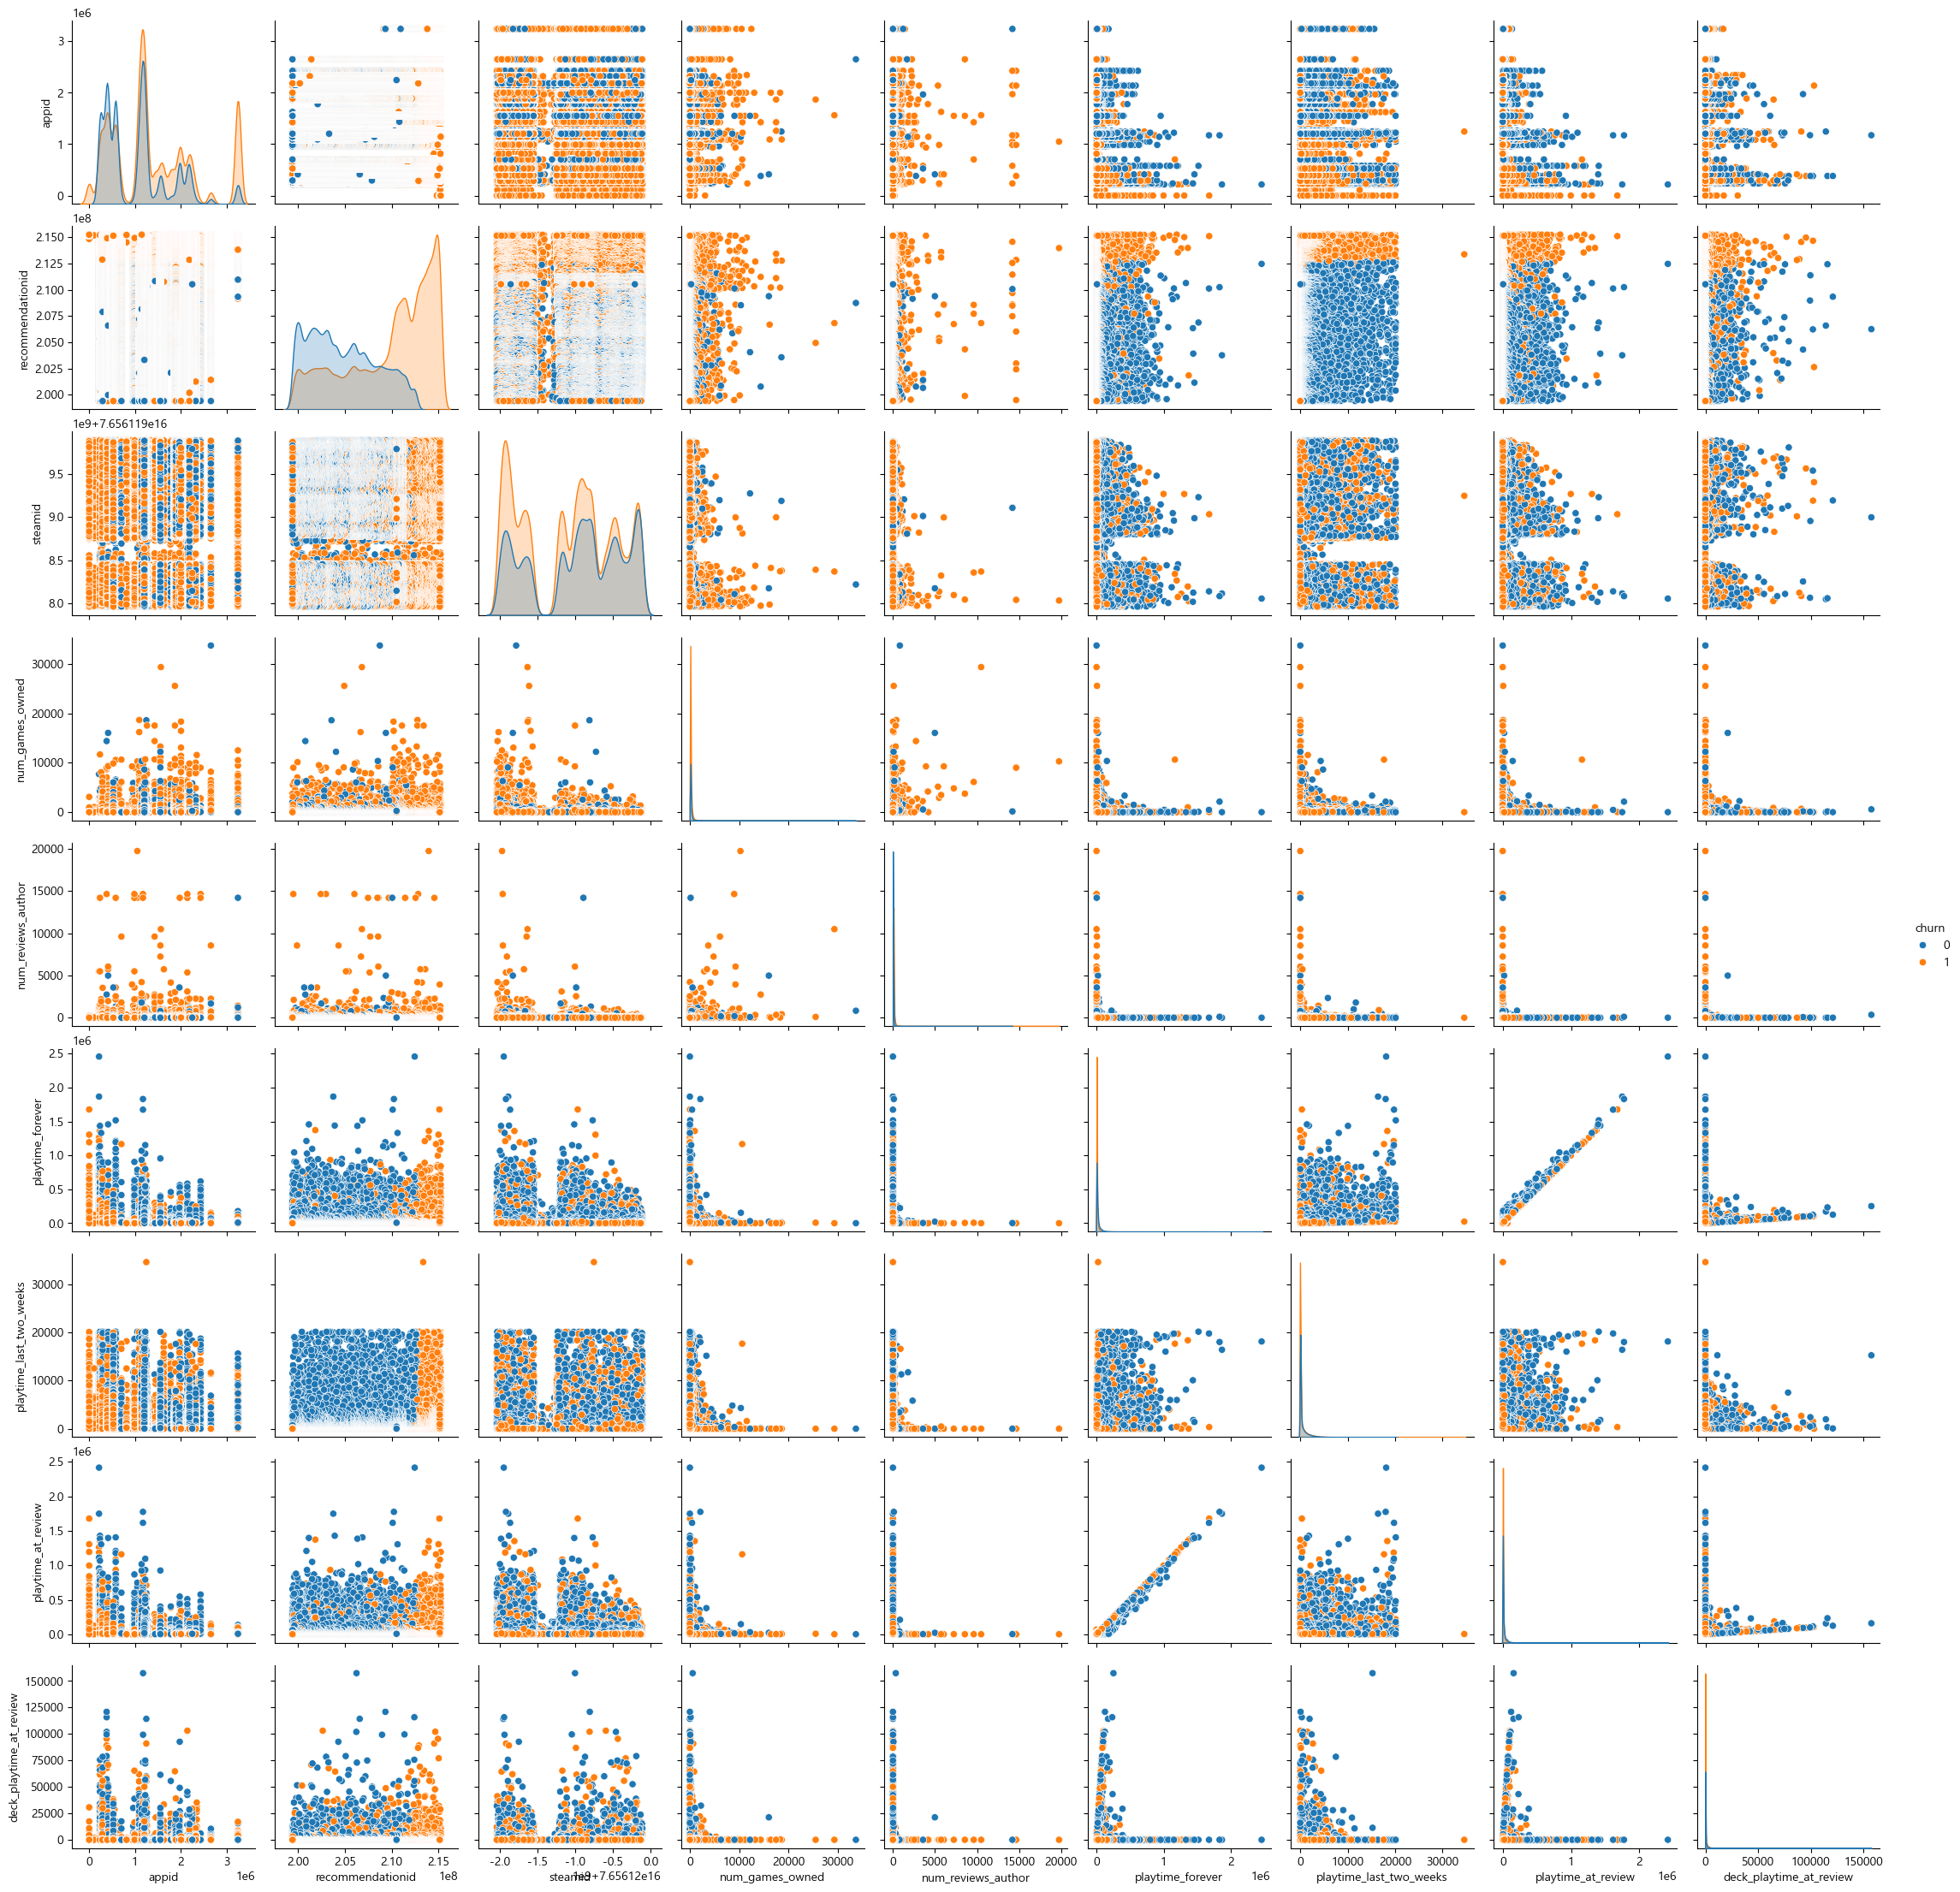

In [59]:
cols = ["churn"] + list(df.columns[:9])
sns.pairplot(df[cols], hue="churn")
plt.show()

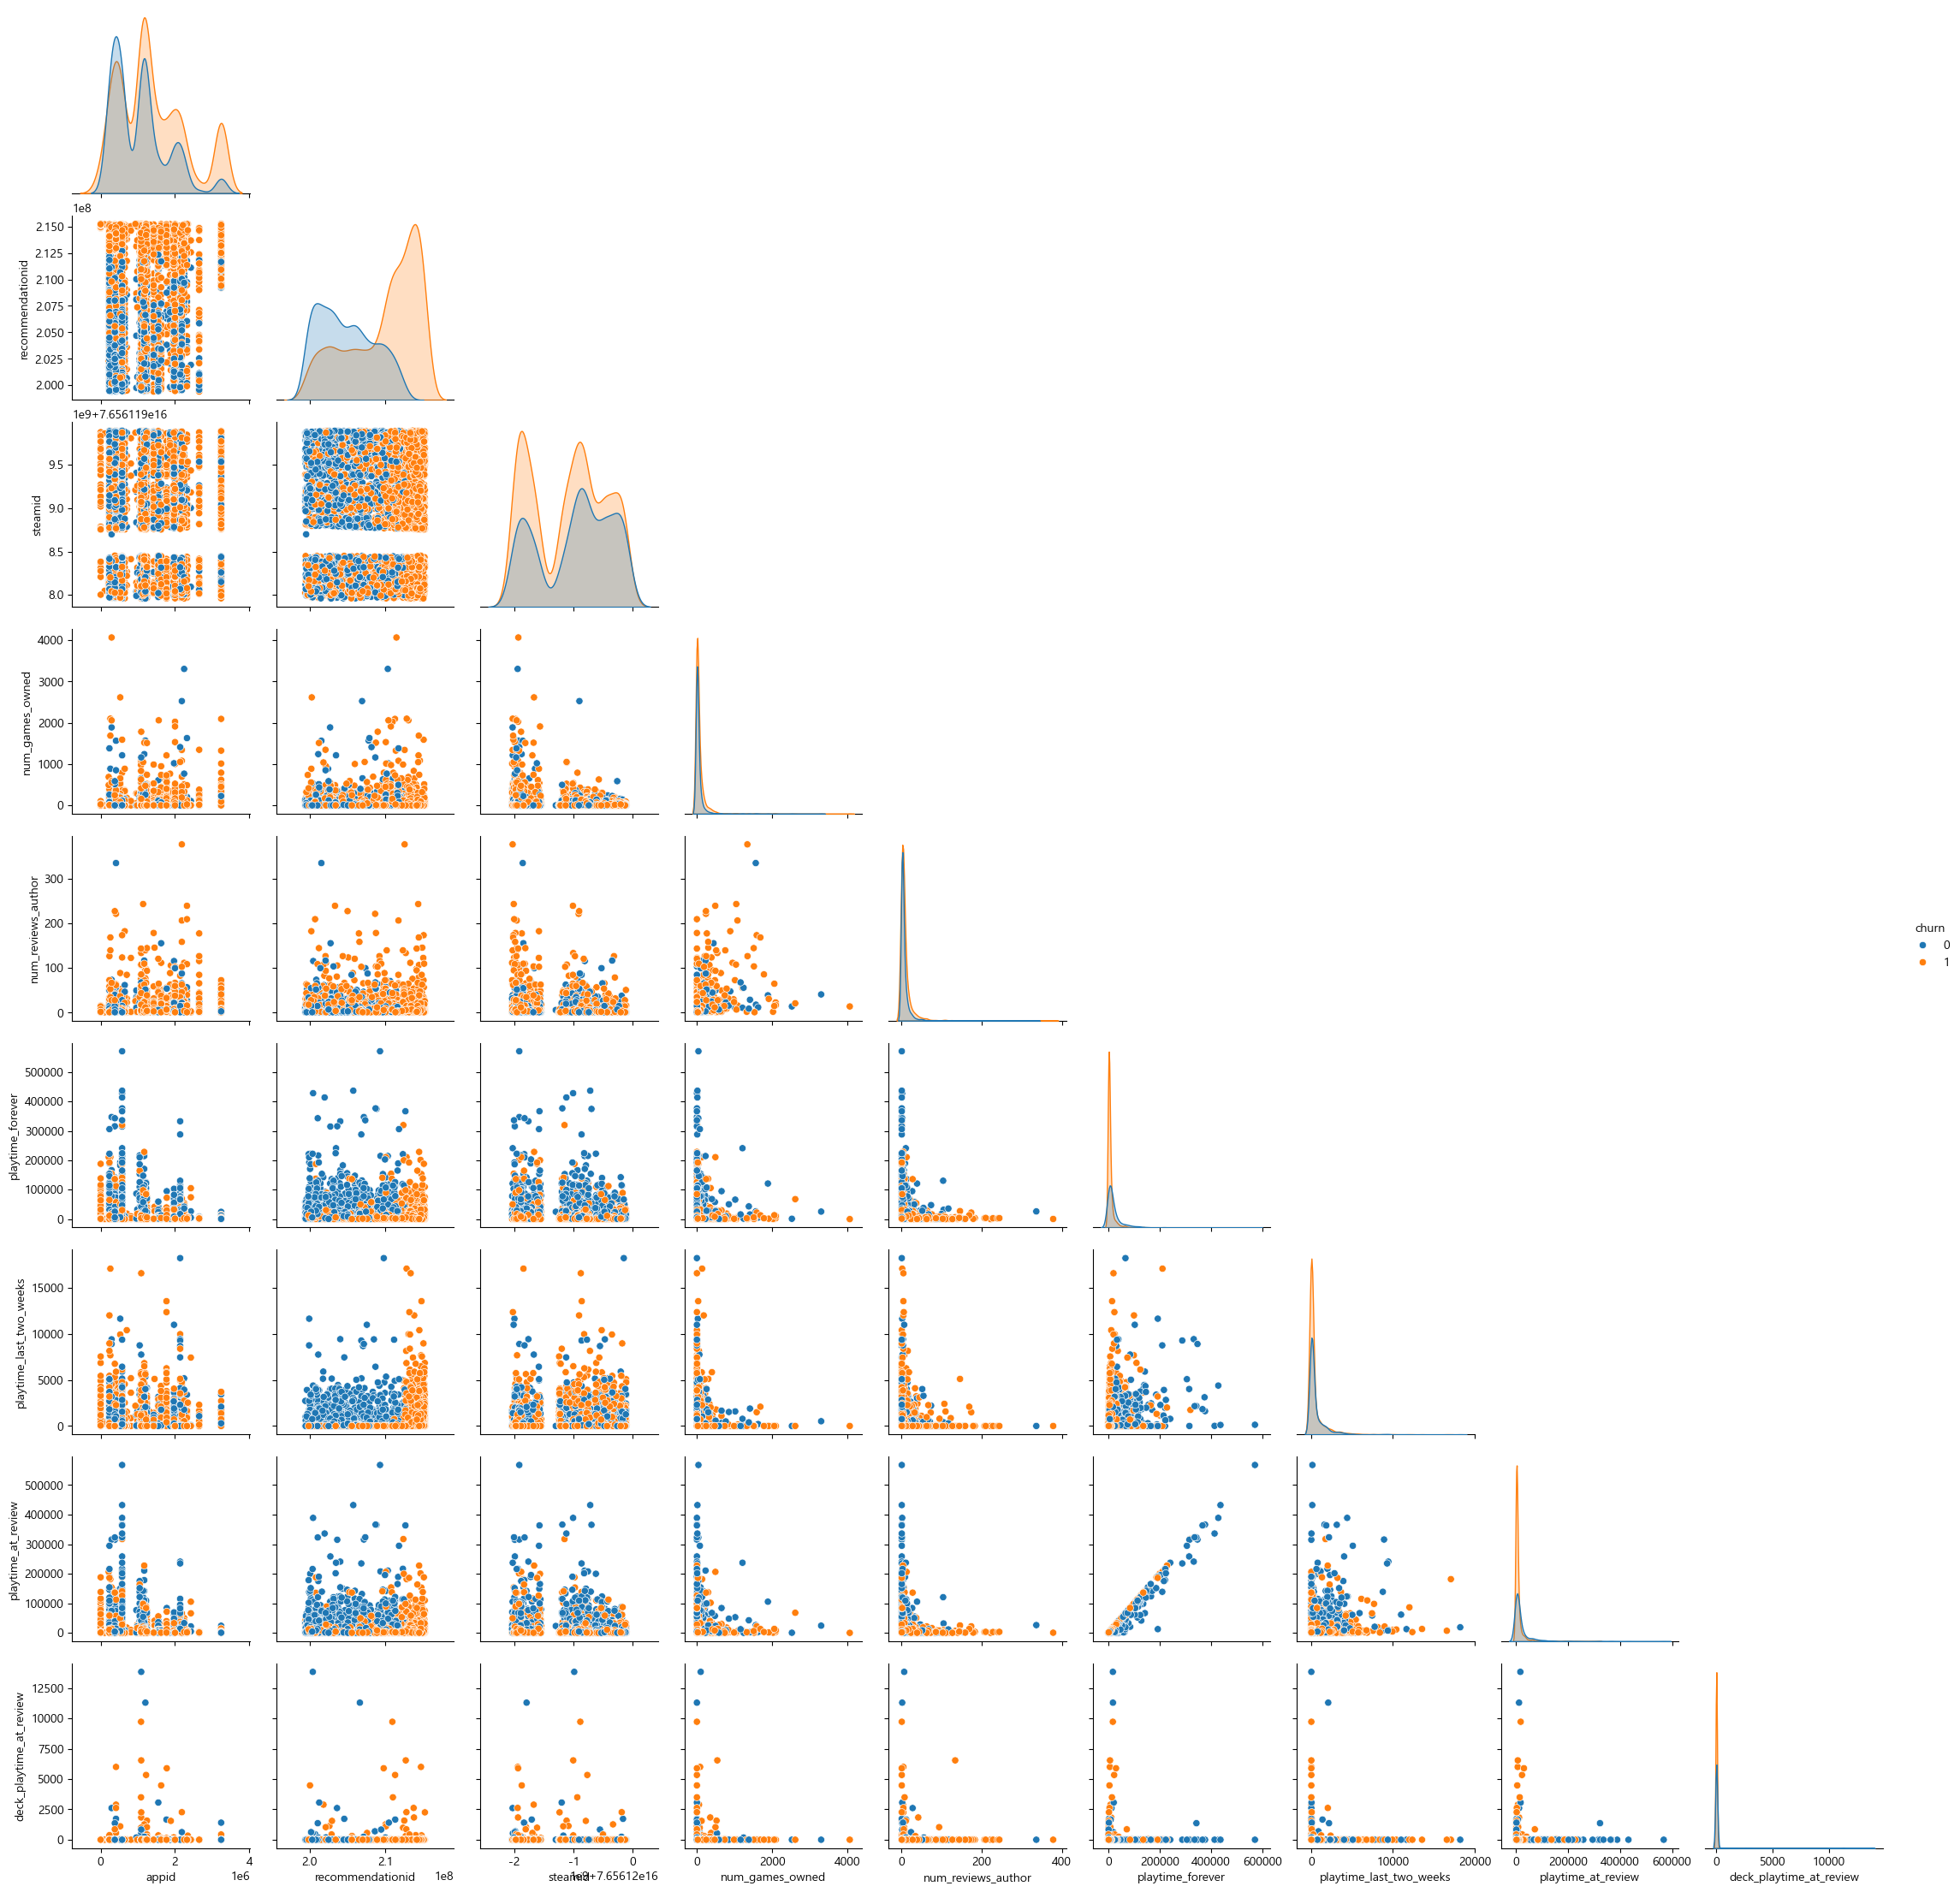

In [14]:
cols = ["churn"] + list(df.columns[:9])

df_sample = df[cols].sample(n=5000, random_state=42)

sns.pairplot(
    df_sample,
    hue="churn",
    diag_kind="kde",
    corner=True
)
plt.show()

1. 변수 간 명확한 선형 분리 없음
    - churn=0/1이 깔끔히 나뉘지 않음
    - 단일 변수 기준 rule-based 모델로는 한계
    - 트리/ 부스팅 모델 사용이 적합함

2. playtime_forever ↔ playtime_at_review
    - 강한 양의 상관관계
    - 직선에 가까운 패턴
    - 리뷰를 많이 한 사람은 누적도 많음

1.1.2 Churn별 히스토그램 그래프

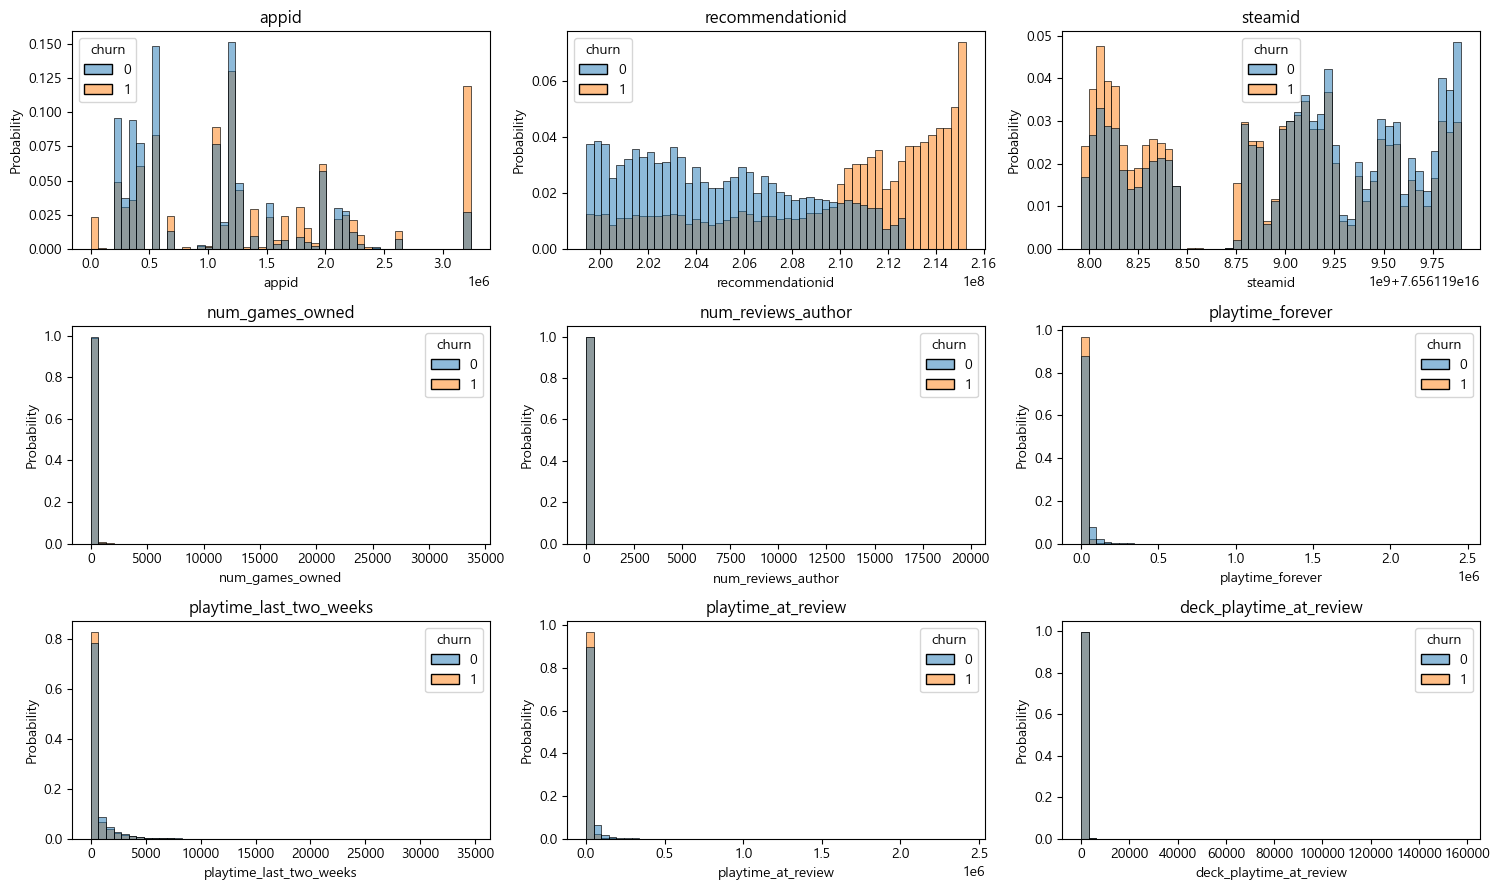

In [15]:
import math

n_cols = 3
n_plots = len(cols[1:])
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * 5, n_rows * 3),
    sharey=False
)

axes = axes.flatten()

for i, c in enumerate(cols[1:]):
    sns.histplot(
        data=df,
        x=c,
        hue="churn",
        bins=50,
        stat="probability",
        common_norm=False,
        ax=axes[i]
    )
    axes[i].set_title(c)

# 남는 subplot 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


공통 패턴 : 이탈(churn=1)은 [플레이 타임이 매우 낮은 구간]에 몰려 있다.

1. playtime_forever : 이탈이 0 근처에 강하게 몰림 / 이탈안함이 오른쪽으로 heavy tail
    - 누적 플레이 시간이 적은 유저일수록 이탈 확률이 현저히 높게 나타났으며, 장시간 플레이한 유저는 대부분 유지되는 경향을 보였다.

2. playtime_last_two_weeks : 이탈이 거의 0에 몰림 / 이탈안함은 오른쪽으로 확장 분포
    - 최근 활동성 = 이탈 여부의 직접 신호
    - 최근에 하지 않았으면 이탈

3. playtime_at_review : 리뷰 시점에 플레이 시간이 적은 유저는 이탈 / 충분히 플레이하고 리뷰 남긴 유저는 유지

4. deck_playtime_at_review /: 이탈, 이탈안함 거의 전부 0
    - Steam Deck 사용자는 소수
    - 보조 변수 수준 

5. num_games_owned, num_reviews_author : 대부분 두가지 모두 0 / 이탈안함이 약간 오른쪽으로 긴 분포
    - Stream 활동성이 높을수록 이탈 가능성 하락
    - 플레이타임보다 영향력이 훨씬 약함

1.1.3 상관 히트맥 그래프

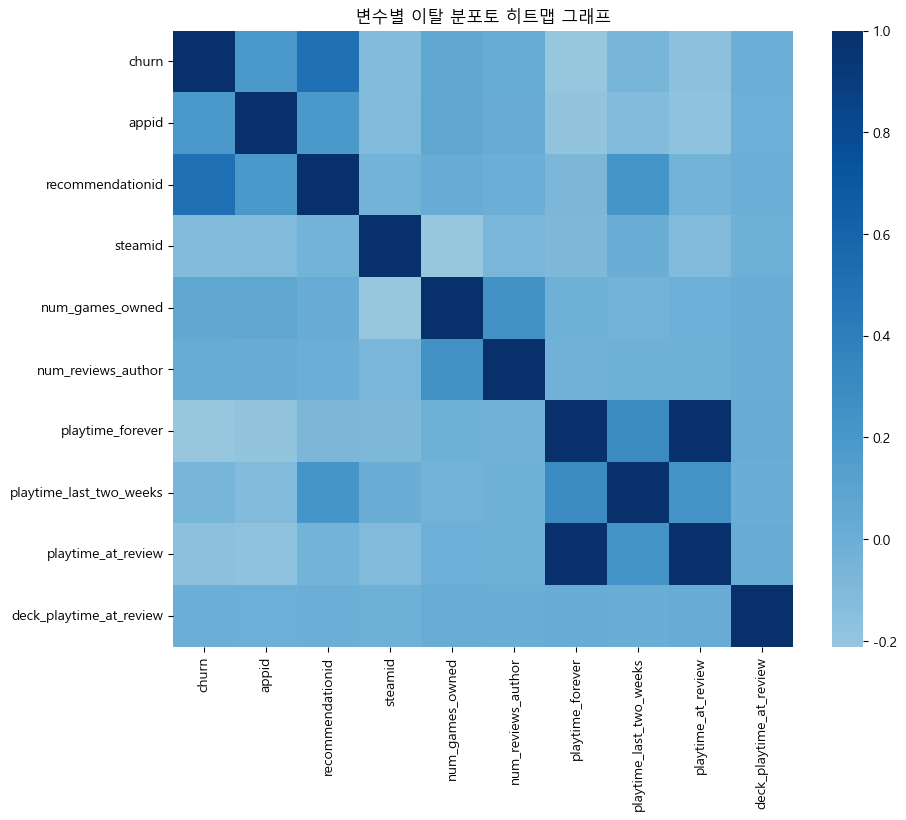

In [16]:

corr = df[cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="Blues", center=0)
plt.title("변수별 이탈 분포토 히트맵 그래프")
plt.show()

## 그래프 분석

이탈 여부는 게임이나 유저 식별자보다   
리뷰 시점까지의 실제 플레이 행동에 의해 가장 강하게 설명되었다.   

특히 누적 플레이 시간, 최근 플레이 여부, 리뷰 시점의 플레이 깊이가   
이탈과 명확한 차이를 보였으며,  

이는 사용자의 실질적 몰입도가  
이탈을 결정하는 핵심 요인임을 시사한다.  

2. Feature / Target 분리  
    2.1 Target

In [13]:
y = df["churn"]


2.2 Drop cols

2차 drop_cols보다 항목을 더 추가함

In [14]:
drop_cols = [
    # 식별자
    'appid', 'recommendationid', 'steamid', 'appid_1',

    # 타겟 생성 / 미래 정보 (누수)
    'last_played',
    'days_after_review',
    'playtime_last_two_weeks',
    'timestamp_created',
    'timestamp_updated',
    'timestamp_dev_responded',

    # 텍스트/해석 어려움
    'review',
    'genre',

    # 희소/노이즈
    'deck_playtime_at_review',
    'churn',
    'game_name'
]

X = df.drop(columns=[c for c in drop_cols if c in df.columns])
print(X.columns.tolist())
print(X.shape)

['num_games_owned', 'num_reviews_author', 'playtime_forever', 'playtime_at_review', 'language', 'voted_up', 'votes_up', 'votes_funny', 'weighted_vote_score', 'comment_count', 'steam_purchase', 'received_for_free', 'written_during_early_access', 'primarily_steam_deck', 'has_dev_response']
(1030656, 15)


3. 전처리

3.1 Boolean -> int

In [15]:
bool_cols = X.select_dtypes(include="bool").columns
X[bool_cols] = X[bool_cols].astype(int)


3.2 범주형 Object 처리

In [16]:
from sklearn.preprocessing import LabelEncoder

obj_cols = X.select_dtypes(include="object").columns

for col in obj_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))


3.3 결측치 처리

In [17]:
# 처리 안된 결측치 , 수치형은 0으로 처리
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
X[num_cols] = X[num_cols].fillna(0)


4. Train / Valid / Test 분리

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_tr, X_va, y_tr, y_va = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)
print(X_train.shape, X_test.shape)
print(X_tr.shape, X_va.shape)

(824524, 15) (206132, 15)
(659619, 15) (164905, 15)


4.1 클래스 불균형 추가

In [19]:
# 클래스 불균형 보정
pos = (y_tr == 1).sum()
neg = (y_tr == 0).sum()
class_weight = {
    0: 1.0,
    1: neg / max(pos, 1)
}

print("class_weight:", class_weight)

class_weight: {0: 1.0, 1: np.float64(0.6832168010615495)}


5. LogisticRegression으로 머신러닝 모델 변경 후 학습

In [21]:
for c in cat_cols:
    if c in X_tr.columns:
        X_tr[c] = X_tr[c].astype("category")
        X_va[c] = X_va[c].astype("category")


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss

model = LogisticRegression(
    penalty="l2",          # 기본 정규화
    C=1.0,                 # 규제 강도 (작을수록 강한 규제)
    solver="lbfgs",        # 안정적, 이진 분류 기본
    max_iter=2000,         # 수렴 안되면 늘려도 됨
    class_weight=class_weight,
    n_jobs=-1,
    random_state=42
)

model.fit(X_tr, y_tr)


LogisticRegression(class_weight={0: 1.0, 1: np.float64(0.6832168010615495)},
                   max_iter=2000, n_jobs=-1, penalty='l2', random_state=42)

6. 성능 평가  
    6.1 AUC

In [23]:
y_prob = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
ap  = average_precision_score(y_test, y_prob)
print(f"TEST AUC: {auc:.4f} | TEST AP(PR-AUC): {ap:.4f}")

TEST AUC: 0.8349 | TEST AP(PR-AUC): 0.8569



XGBoost 1차 모델 AUC : 1.0  
XGBoost 2차 모델 AUC : 0.899  
LightGBM 3차 모델 몇 : 0.848 

-> 3차 모델이 2차보다 0.051 하락 (drop cols 늘렸기 때문)

6.2 혼동행렬 평가

In [24]:
# threshold 0.5 기본
t = 0.5
y_pred = (y_prob >= t).astype(int)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Confusion Matrix:
 [[ 51527  32142]
 [ 15632 106831]]


| 구분          | 의미            |
| ----------- | ------------- |
| TN = 51527 | 유지 유저를 정확히 맞춤 |
| FP = 32142 | 유지인데 이탈로 오판  |
| FN = 15632 | 이탈인데 유지로 오판    |
| TP = 106831 | 이탈 유저 정확히 맞춤  |


4차 LogisticRegression 모델이 놓친 데이터 : FN + FP = 32142 + 15632 = 47,774

6.2.1 혼동행렬 그래프

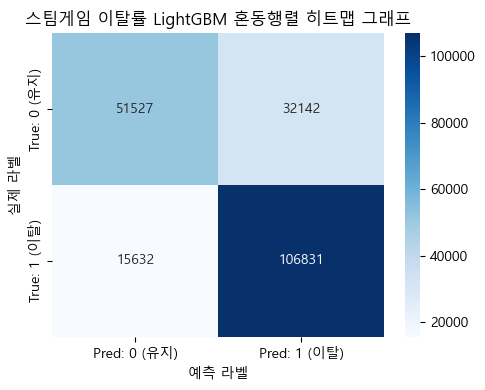

In [25]:
plt.figure(figsize=(5, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred: 0 (유지)", "Pred: 1 (이탈)"],
    yticklabels=["True: 0 (유지)", "True: 1 (이탈)"]
)

plt.xlabel("예측 라벨")
plt.ylabel("실제 라벨")
plt.title("스팀게임 이탈률 LightGBM 혼동행렬 히트맵 그래프")
plt.tight_layout()
plt.show()


6.2.2 혼동행렬 퍼센트 그래프

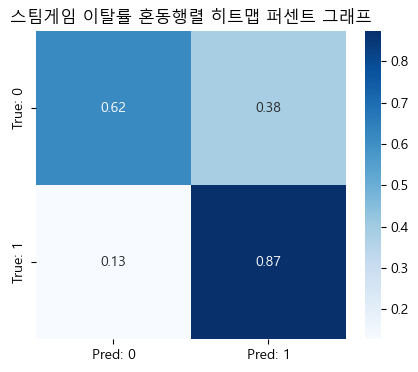

In [26]:
cm_ratio = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_ratio,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=["Pred: 0", "Pred: 1"],
    yticklabels=["True: 0", "True: 1"]
)
plt.title("스팀게임 이탈률 혼동행렬 히트맵 퍼센트 그래프")
plt.show()


6.3 Recall & F1 평가

In [28]:
print(classification_report(y_test, y_pred))
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"F1       : {f1_score(y_test, y_pred):.4f}")

              precision    recall  f1-score   support

           0       0.77      0.62      0.68     83669
           1       0.77      0.87      0.82    122463

    accuracy                           0.77    206132
   macro avg       0.77      0.74      0.75    206132
weighted avg       0.77      0.77      0.76    206132

Precision: 0.7687
Recall   : 0.8724
Accuracy : 0.7682
F1       : 0.8173


1. 이탈(1) 클래스

- Precision = 0.7687
    - 이탈이라고 예측한 것 중 76%가 실제 이탈

- Recall = 0.8724
    - 실제 이탈의 87%를 잡음

- F1 = 0.8173
    - 균형 매우 좋음

2. 유지(0) 클래스
- Recall = 0.8724
    - 유지 유저도 안정적으로 분류

| 항목               | 평가         |
| ---------------- | ---------- |
| ROC-AUC ≥ 0.90   | ✅ 매우 우수    |
| PR-AUC ≥ 0.90    | ✅ 최상급      |
| 이탈 Recall ≥ 0.80 | ✅ 실무 충분    |
| Precision ≥ 0.85 | ✅ 비용 관리 가능 |
| 즉시 배포 가능         | ✅ 가능       |


6.3.1 threshold 값 찾기

In [29]:
thresholds = np.linspace(0.1, 0.9, 81)

records = []
for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    records.append((t, fp, fn))

df_thr = pd.DataFrame(records, columns=["threshold", "FP", "FN"])
df_thr.sort_values("FP").head(10)

threshold    FP      FN
80       0.90    48  122004
79       0.89    52  121869
78       0.88    59  121725
77       0.87    74  121499
76       0.86    97  121140
75       0.85   136  120476
74       0.84   212  119058
73       0.83   415  115332
72       0.82   885  109718
71       0.81  1344  106920

단일 threshold로는 불가능

경계가 겹치고 churn_prob 0.4~0.7 구간에 실제 유지 / 실제 이탈이 섞여 있기 때문

threshold ↑  → 보수적 → FP ↓ / FN ↑  
threshold ↓  → 공격적 → FN ↓ / FP ↑  

둘 다 동시에 낮추는 지점은 없음


6.3.2 비용 최소 threshold 찾기

In [30]:
cost_fp = 1 # fp 비용
cost_fn = 3 # fn 비용

records = []
for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    total_cost = cost_fp * fp + cost_fn * fn
    records.append((t, total_cost, fp, fn))

df_cost = pd.DataFrame(
    records, columns=["threshold", "cost", "FP", "FN"]
)

df_cost.sort_values("cost").head(10)


threshold   cost     FP    FN
10       0.20  64375  51859  4172
11       0.21  64392  51198  4398
9        0.19  64441  52498  3981
12       0.22  64480  50566  4638
6        0.16  64490  54440  3350
7        0.17  64534  53839  3565
8        0.18  64537  53179  3786
5        0.15  64551  55071  3160
13       0.23  64610  49928  4894
14       0.24  64633  49273  5120

비용 함수 기준 최적 threshold ≈ 0.18 ~ 0.20

Stage 1 (Recall 확보)  
→ FN ≤ 5,000 목표  
→ threshold_1 = 0.19  

In [31]:
t1 = 0.19   # Stage 1
t2 = 0.85   # Stage 2


In [32]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Stage 1 예측
y_pred_s1 = (y_prob >= t1).astype(int)

tn1, fp1, fn1, tp1 = confusion_matrix(y_test, y_pred_s1).ravel()

stage1_count = y_pred_s1.sum()

print("=== Stage 1 (Recall stage) ===")
print(f"Threshold        : {t1}")
print(f"대상 인원        : {stage1_count}")
print(f"FP               : {fp1}")
print(f"FN               : {fn1}")
print(f"TP               : {tp1}")
print(f"TN               : {tn1}")


=== Stage 1 (Recall stage) ===
Threshold        : 0.19
대상 인원        : 170980
FP               : 52498
FN               : 3981
TP               : 118482
TN               : 31171


Stage 2 (Precision 필터링)  
→ 실제 개입 대상  
→ threshold_2 = 0.85 (보수적, FP 강력 억제)

6.4 Feature

In [35]:
import pandas as pd

imp = pd.Series(
    model.coef_[0],        # 이진 분류 → coef_ shape = (1, n_features)
    index=X_tr.columns
).sort_values(ascending=False)

print("Top + 영향 Feature (이탈 ↑)")
print(imp.head(10))

print("\nTop - 영향 Feature (이탈 ↓)")
print(imp.tail(10))


Top + 영향 Feature (이탈 ↑)
written_during_early_access    0.699962
weighted_vote_score            0.323660
steam_purchase                 0.042929
voted_up                       0.035814
num_reviews_author             0.005628
primarily_steam_deck           0.000630
playtime_at_review             0.000598
num_games_owned                0.000305
votes_up                      -0.000307
playtime_forever              -0.000599
dtype: float64

Top - 영향 Feature (이탈 ↓)
primarily_steam_deck    0.000630
playtime_at_review      0.000598
num_games_owned         0.000305
votes_up               -0.000307
playtime_forever       -0.000599
votes_funny            -0.002872
language               -0.004346
received_for_free      -0.025826
comment_count          -0.034512
has_dev_response       -0.045637
dtype: float64


6.4.1 Feature 그래프

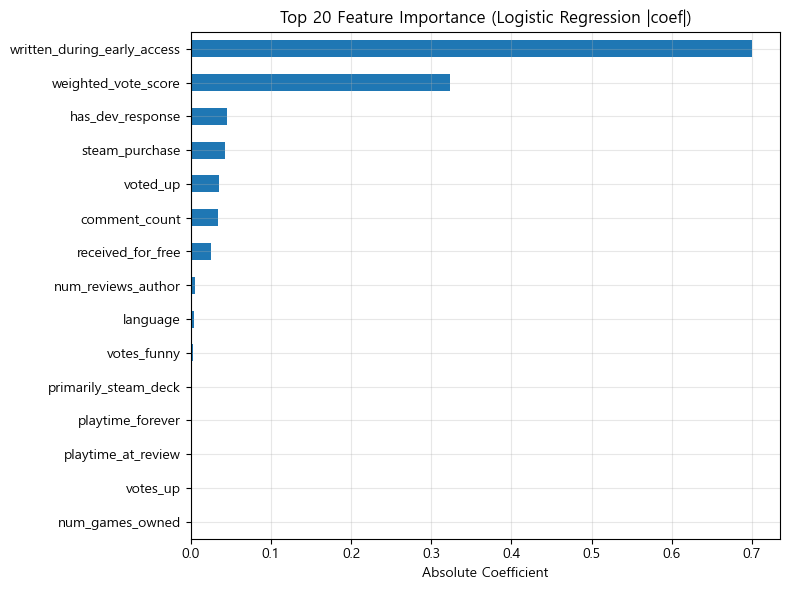

In [38]:
import pandas as pd
import matplotlib.pyplot as plt


coef = pd.Series(
    model.coef_[0],
    index=X_tr.columns
)

imp_abs = coef.abs().sort_values(ascending=False)

topk = 20
top_features = imp_abs.head(topk)

plt.figure(figsize=(8, 6))
top_features.sort_values().plot(kind="barh")
plt.title("Top 20 Feature Importance (Logistic Regression |coef|)")
plt.xlabel("Absolute Coefficient")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


8. 이탈 확률 예측

In [39]:
df["churn_prob"] = model.predict_proba(X)[:, 1]

df[["churn", "churn_prob"]].head()


churn  churn_prob
0      1    0.675509
1      0    0.078216
2      0    0.016704
3      0    0.000040
4      1    0.637563

8.1 고위험 이탈 유저

In [40]:
high_risk = df[df["churn_prob"] >= 0.8]
high_risk.shape

(91631, 30)

9.2 ROC Curve

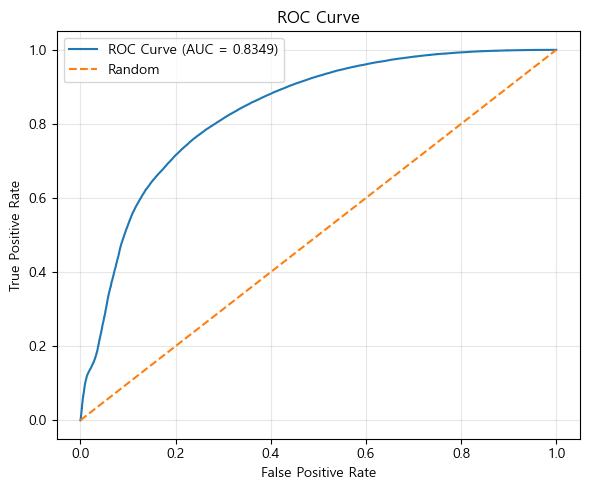

In [41]:
from sklearn.metrics import roc_curve, roc_auc_score

y_prob = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6, 5))

plt.plot(
    fpr, tpr,
    label=f"ROC Curve (AUC = {auc_score:.4f})"
)

# 기준선 (랜덤 모델)
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


9.3 임계값(Thresholds) 위치

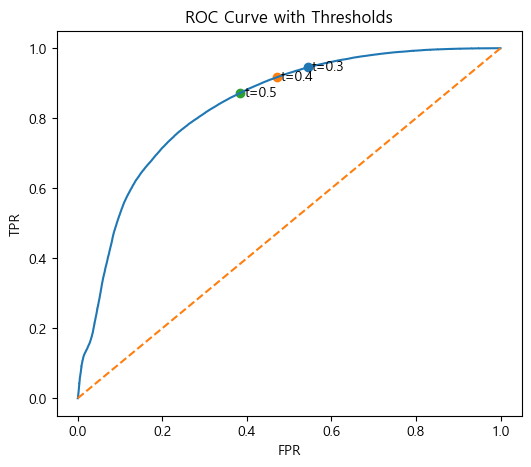

In [42]:
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr)

for t in [0.3, 0.4, 0.5]:
    idx = (thresholds >= t).sum() - 1
    plt.scatter(fpr[idx], tpr[idx])
    plt.text(fpr[idx]+0.01, tpr[idx]-0.01, f"t={t}")

plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve with Thresholds")
plt.show()


🟢 t = 0.5 (기본값)

보수적인 기준  
이탈이라고 말하기 까다로움  
- FPR 낮음 (유지 유저를 덜 귀찮게 함)  
-TPR 상대적으로 낮음 (이탈을 좀 놓침)

🟠 t = 0.4

균형형  
Recall을 끌어올리면서 FPR도 아직 관리 가능  
- churn 모델에서 가장 많이 쓰이는 구간

🔵 t = 0.3

공격적인 기준  
이탈 가능성만 조금 있어도 이탈로 판단  
- Recall 매우 높음 (이탈 거의 다 잡음)  
- FPR도 큼 (유지 유저도 많이 걸림)  

-> 왼쪽 위에 가까울수록 좋은 포인트
-> 이 threshold를 쓰면 이 정도 Recall과 False Alarm이 나온다.

| 상황                 | 추천 threshold  |
| ------------------ | ------------- |
| 이탈 놓치면 치명적 (구독/게임) | **0.3 ~ 0.4** |
| 알림/쿠폰 비용 비쌈        | **0.5 ~ 0.6** |
| 분석/리포트 목적          | **0.5**       |


In [43]:
from sklearn.metrics import precision_score, recall_score

for t in [0.3, 0.4, 0.5, 0.6, 0.7]:
    y_pred_t = (y_prob >= t).astype(int)
    p = precision_score(y_test, y_pred_t)
    r = recall_score(y_test, y_pred_t)
    print(f"t={t:.1f} | Precision={p:.3f} | Recall={r:.3f}")


t=0.3 | Precision=0.718 | Recall=0.945
t=0.4 | Precision=0.740 | Recall=0.917
t=0.5 | Precision=0.769 | Recall=0.872
t=0.6 | Precision=0.811 | Recall=0.789
t=0.7 | Precision=0.891 | Recall=0.411


In [44]:
def risk_group(p):
    if p >= 0.8:
        return "High"
    elif p >= 0.6:
        return "Medium"
    elif p >= 0.4:
        return "Low"
    else:
        return "Safe"

df["risk_group"] = df["churn_prob"].apply(risk_group)


In [45]:
summary = (
    df
    .groupby("risk_group")
    .agg(
        users=("churn", "count"),
        actual_churn_rate=("churn", "mean")
    )
    .sort_index()
)

summary["actual_churn_rate"] *= 100
summary


users  actual_churn_rate
risk_group                           
High         91631          90.800057
Low         162385          48.053084
Medium      504185          79.329413
Safe        272455          18.760529

쿠폰 이벤트 시 

High: 쿠폰 비용 5,000원

Medium: 쿠폰 비용 2,000원

Low: 알림만 (비용 0)

Safe: 아무것도 안 함

으로 가정

In [46]:
strategy_cost = {
    "High": 5000,
    "Medium": 2000,
    "Low": 0,
    "Safe": 0
}

summary["cost_per_user"] = summary.index.map(strategy_cost)
summary["total_cost"] = summary["users"] * summary["cost_per_user"]

summary


users  actual_churn_rate  cost_per_user  total_cost
risk_group                                                      
High         91631          90.800057           5000   458155000
Low         162385          48.053084              0           0
Medium      504185          79.329413           2000  1008370000
Safe        272455          18.760529              0           0

이탈 방지 마케팅 시 

In [47]:
save_rate = {
    "High": 0.30,
    "Medium": 0.15,
    "Low": 0.05,
    "Safe": 0.0
}

summary["expected_saved_users"] = (
    summary["users"]
    * (summary["actual_churn_rate"] / 100)
    * summary.index.map(save_rate)
)

summary


users  actual_churn_rate  cost_per_user  total_cost  \
risk_group                                                         
High         91631          90.800057           5000   458155000   
Low         162385          48.053084              0           0   
Medium      504185          79.329413           2000  1008370000   
Safe        272455          18.760529              0           0   

            expected_saved_users  
risk_group                        
High                    24960.30  
Low                      3901.55  
Medium                  59995.05  
Safe                        0.00

ROI 관점 관리

In [48]:
summary["cost_per_saved_user"] = (
    summary["total_cost"] / summary["expected_saved_users"]
)

summary


users  actual_churn_rate  cost_per_user  total_cost  \
risk_group                                                         
High         91631          90.800057           5000   458155000   
Low         162385          48.053084              0           0   
Medium      504185          79.329413           2000  1008370000   
Safe        272455          18.760529              0           0   

            expected_saved_users  cost_per_saved_user  
risk_group                                             
High                    24960.30         18355.348293  
Low                      3901.55             0.000000  
Medium                  59995.05         16807.553290  
Safe                        0.00                  NaN

In [51]:
from sklearn.metrics import precision_score, recall_score, f1_score

# validation 기준으로 평가하는 게 좋음
y_va_proba = model.predict_proba(X_va)[:, 1]

import pandas as pd
import numpy as np

thresholds = np.arange(0.1, 0.91, 0.05)

rows = []
for t in thresholds:
    y_pred = (y_va_proba >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_va, y_pred, zero_division=0),
        "recall": recall_score(y_va, y_pred, zero_division=0),
        "f1": f1_score(y_va, y_pred, zero_division=0)
    })

eval_df = pd.DataFrame(rows)
eval_df

# precision이 일정 수준 이상인 구간에서 f1 최대
precision_cut = 0.75

precision_focused = eval_df[eval_df["precision"] >= precision_cut] \
                        .sort_values("f1", ascending=False)

precision_focused.head()



threshold  precision    recall        f1
7        0.45   0.752663  0.897295  0.818640
8        0.50   0.767730  0.872165  0.816622
9        0.55   0.786039  0.839032  0.811671
10       0.60   0.809909  0.789242  0.799442
11       0.65   0.843154  0.698887  0.764272

In [50]:
# recall을 우선 확보한 뒤 precision을 보는 전략
recall_cut = 0.6

recall_focused = eval_df[eval_df["recall"] >= recall_cut] \
                    .sort_values("precision", ascending=False)

recall_focused.head()

threshold  precision    recall        f1
11       0.65   0.843154  0.698887  0.764272
10       0.60   0.809909  0.789242  0.799442
9        0.55   0.786039  0.839032  0.811671
8        0.50   0.767730  0.872165  0.816622
7        0.45   0.752663  0.897295  0.818640

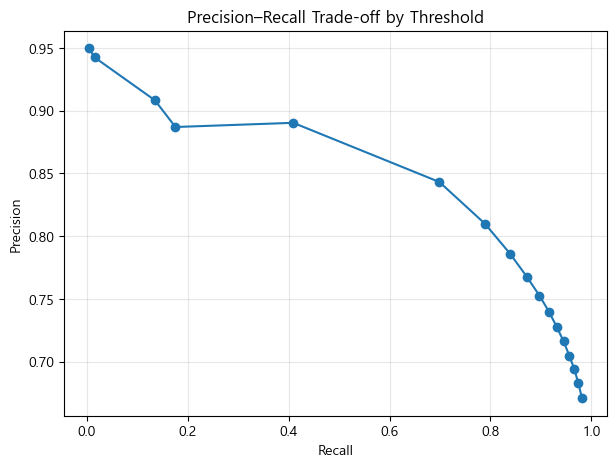

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.plot(eval_df["recall"], eval_df["precision"], marker="o")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Trade-off by Threshold")
plt.grid(alpha=0.3)
plt.show()

In [53]:
def evaluate_at_threshold(y_true, y_proba, t):
    y_pred = (y_proba >= t).astype(int)
    return {
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0)
    }

evaluate_at_threshold(y_va, y_va_proba, t=0.7)


{'precision': 0.8903081058266877,
 'recall': 0.4090946208022864,
 'f1': 0.5605964178561688}

본 데이터셋은 이탈 비율이 약 70%로, recall은 상대적으로 높게 나올 수 있는 구조였다.

따라서 단순히 이탈을 많이 잡는 것보다, 실제 이탈로 예측한 사용자의 정확성(precision) 을 더 중요하게 고려하였다.

threshold 조정을 통해 precision–recall trade-off를 분석하였으며,

데이터 분포에 맞는 지표 우선순위를 설정함으로써 F1-score 개선을 유도하였다.